# INF8111 - Data Mining

## TP1 FALL 2020 - Duplicate Bug Report Detection

##### Due date: 23/05

##### Team Members:

    - Vithor Bertalan - 2135362 - 1
    
##### Deliverables:

You must submit two separate files to Moodle:
1. Notebook
2. [Json](https://en.wikipedia.org/wiki/JSON) containing scraped web-page content (bug_reports.json)


## 1 - Overview


Due to complexities of software systems, software bugs are prevalent. Companies, especially large ones, usually use a Bug Tracking System (BTS), also called Issue Tracking System, to manage and track records of bugs. Besides developers and testers, many projects, mainly open source projects, allow users to report new bugs in their BTS.
To do that, users have to fill a form with multiple fields. An important subset of
these fields provides categorical data and only accepts values that range from a fixed list of
options (e.g., component, version and product of the system). Another two important fields
are the summary and the description. The users are free to write anything in both fields
and the only constraint is that the summary has a maximum number of characters. The
submission of a form creates a page, called bug report or issue report, which contains all
the information about a bug.

Due to the lack of communication and syncronization, users may not be aware that a specific bug was already submitted and report it again. Identifying duplicate bug reports is important task in the BTSs and it is the subject of this TP. Basically, our goal is to develop a system that will compare a new bug report with the submitted ones and rank them based on textual similarity. This ranked list will be used by a triager to manually identify whether a report is duplciate or not.

# 2 Setup

Please run the code below to install the packages needed for this assignment.

In [ ]:
                                                                                                                                                                                                                # If you want, you can use anaconda and install after nltk library
# pip install --user numpy
# pip install --user sklearn
# pip install --user scipy
# pip install --user nltk
# pip install --user tqdm


#python
#import nltk
#nltk.download("punkt")

# 3 - Data

Please download the zip file in the following url: https://drive.google.com/file/d/14BrFaOiVDIcpjwpm5iAkAy0v_moZyGiP/view?usp=sharing

In this zip file, there are: 

1. test.json: This file contains duplicate bug reports that will be used to evaluate our system.
2. bug_reports: It is a folder that contains the bug report html source. Each html file name follows the pattern **bug_report_id.html**.


Figure below depicts an bug report page example:


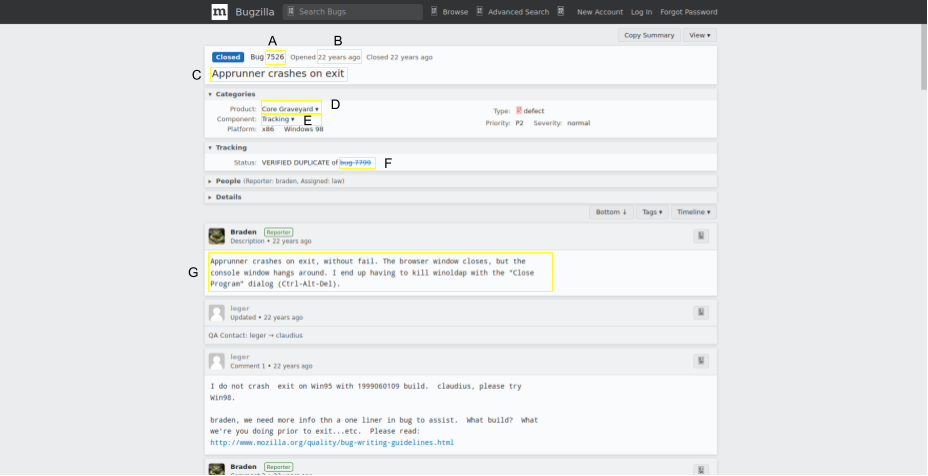

In [1]:
from IPython import display
display.Image("https://i.ibb.co/X7mHZbY/bug-report.png")

- A : bug report id
- B : creation date
- C : summary
- D : product
- E : component
- F : the report id which the bug report is duplicate
- G : description

The following script loads the test dataset and define some global variables:

In [78]:
import os
from scipy.sparse import csr_matrix
from lxml import etree
import numpy as np

# define the folder path that contain the data
# FOLDER_PATH = "Define folder path that contain threads folder and test.json"
#FOLDER_PATH = "INF8111_2020_fall_tp1_dataset_subset/dataset/"
FOLDER_PATH = "INF8111_2020_fall_tp1_dataset/dataset/"
PAGE_FOLDER = os.path.join(FOLDER_PATH, 'bug_reports')

# Load the evaluation dataset
import json

test = json.load(open(os.path.join(FOLDER_PATH, "test.json")))

# 4 - Web scraping

Web scraping consists in extracting relevant data from pages and prepare it for computational analysis.


## 4.1 - Question 1 (2 points)

Implement extract_data_from_page function. This function extracts the following information from the html: bug report id, creation date, title, product, component, the report id which it is duplicate and description.

*extract_data_from_page* function returns a dictionary with the following structure:


 ```python
{"report_id": int, 
  "dup_id": int or None (the report id which it is duplicate), 
  "component": string, 
  "product": string, 
  "summary": str, 
  "description": string, 
  "creation_date": int}
 ```
For instance, when extract_data_from_page receives "bug_report/7526.html", it returns:
 
```python
{
"report_id": 7526,
"dup_id": 7799,
"product": "core graveyard",
"component":  tracking,
"summary": "Apprunner crashes on exit",
"description": "Apprunner crashes on exit, without fail. The browser window closes, but the
console window hangs around. I end up having to kill winoldap with the \\"Close
Program\\" dialog (Ctrl-Alt-Del).",
"creation_date": 928381771
}
```

**Creation date have to be represented as timestamp. If bug report is not duplicate, dup_id have to be None.**

*HINT: lxml parse is faster than html.parser*

In [84]:
from lxml import etree
import re

## checks if token is a word or an accepted punctuation sign normally used in english words 
## source: https://grammar.yourdictionary.com/punctuation/what/fourteen-punctuation-marks.html
## or if the token does not mix numbers and letters (like "token01", or "0x407c6049", both not valid)
## words might still be numbers or letters ending with punctuations (like "token!" or "08.", both valid)

def isValid (token):
    acceptedPunctuation = '''.?!,;:-—[]{}()'"'''

    for idx, char in enumerate(token):
        if (char.isalpha() == False and char not in acceptedPunctuation):
            return False
        elif (char.isalpha()):
            hasLetter = True
        elif (char in acceptedPunctuation):
            if (idx != 0 and idx != len(token)-1):
                return False
    return True 

## standard method, extracts data from page using LXML parse, iterating on the leaves

def extract_data_from_page(pagepath):

    parser = etree.HTMLParser()
    #parser = etree.LXMLParser()
    tree = etree.parse(pagepath, parser)
    main = tree.getroot()[1][0][2]
    report_id = 0
    dup_id = 0
    component = ""
    product = ""
    summary = ""
    description = " "
    creation_date = 0
    dictionary = {}
    pattern = re.compile(r'[a-z]+[A-Z].*|#.*|.*=.*|---.*|(http|https|ftp|ftps)\:\/\/[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(\/\S*)?')
    
    leaf = main.find('.//*[@id="field-value-bug_id"]')
    if (leaf is not None):
        numbers = ""
        for char in leaf[0].text:
            if char.isdigit():
                numbers+=char
        report_id = (int(numbers))

    leaf = main.findall('.//*[@id="field-value-short_desc"]')
    if (leaf is not None):
        summary = " ".join(leaf[-1].text.split())

    leaf = main.find('.//*[@id="product-name"]')
    if (leaf is not None):
        product = " ".join(leaf.text.split())
        
    leaf = main.find('.//*[@id="component-name"]')
    if (leaf is not None):
        component = " ".join(leaf.text.split())
        
    leaf = main.find('.//*[@id="field-value-status-view"]')
    if (leaf is not None):
        if (leaf.text.find("DUPLICATE") > 0):
            numbers = ""
            for char in leaf[0].text:
                if char.isdigit():
                    numbers+=char
            dup_id = (int(numbers))
        else:
            dup_id = None
        
    leaf = main.find('.//*[@data-time]')
    if (leaf is not None):        
        numbers = ""
        for char in str(leaf.attrib).split(':')[-1]:
            if char.isdigit():
                numbers+=char
        creation_date = (int(numbers))
        
    leaf = main.find('.//*[@id="ct-0"]')

    ## sem substituir nem ver palavra válida
    '''
    for child in leaf.iter('*'):
        if len(child) == 0:
            words = child.text.split()
            for word in words:
                #if (isValid(word)):
                description = description + word + " "    
    '''
    
    ## substituindo e vendo palavra válida

    for child in leaf.iter('*'):
        if len(child) == 0:
            clean_string = re.sub(pattern, '', child.text)
            words = clean_string.split()
            for word in words:
                if (isValid(word)):
                    description = description + word + " "                

    
    ## substitundo, sem ver palavra válida
    '''
    for child in leaf.iter('*'):
        if (child.text):
            print(child.text)
            clean_string = re.sub(pattern, '', child.text)
            words = clean_string.split()
            for word in words:
                description = description + word + " "    
     '''
 
    return  {
            "report_id": report_id,
            "dup_id": dup_id,
            "component": component, 
            "product": product, 
            "summary": summary, 
            "description": description, 
            "creation_date": creation_date
}

## 4.3 - Extract text from HTML


In [85]:
import os
from multiprocessing import Pool, TimeoutError
from time import time
import json
import tqdm

# Index each thread by its id
index_path = os.path.join(PAGE_FOLDER, 'bug_reports.json')

if os.path.isfile(index_path):
    # Load threads that webpage content were already extracted.
    report_index = json.load(open(index_path))
else:
    # Extract webpage content

    # This can be slow (around 10 minutes). Test your code with a small sample. lxml parse is faster than html.parser
    files = [os.path.join(PAGE_FOLDER, filename) for filename in os.listdir(PAGE_FOLDER)]
    reports = [extract_data_from_page(f) for f in tqdm.tqdm(files)]
    report_index = dict(((report['report_id'], report) for report in reports ))

    # Save preprocessed bug reports
    json.dump(report_index, open(index_path,'w'))    


 12%|█████████▏                                                                   | 1196/9998 [00:07<00:55, 159.91it/s]


 24%|██████████████████▋                                                          | 2419/9998 [00:14<00:55, 137.71it/s]


 36%|███████████████████████████▌                                                 | 3580/9998 [00:21<00:41, 155.08it/s]


 47%|████████████████████████████████████▎                                        | 4707/9998 [00:28<00:43, 121.46it/s]


 58%|████████████████████████████████████████████▊                                | 5823/9998 [00:36<00:27, 150.77it/s]


 70%|█████████████████████████████████████████████████████▋                       | 6972/9998 [00:43<00:18, 162.50it/s]


 81%|██████████████████████████████████████████████████████████████▌              | 8125/9998 [00:50<00:11, 166.65it/s]


 93%|███████████████████████████████████████████████████████████████████████▋     | 9311/9998 [00:57<00:04, 168.10it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 9998/9998 [01:01<00:00, 162.51it/s]


In [86]:
index_path = os.path.join(PAGE_FOLDER, 'bug_reports.json')
reports = [r for r in report_index.values()]
        
for idx, report in enumerate(reports):
    print("REPORT ID {}".format(report['report_id']))
    print(report['description'])
    print("********")

REPORT ID 1000
 Goto the above url and click on the talkback Core Dump in Here is a stack trace, The problem is the begin is NULL and being dereferenced. There was no selection when i went to the above url. (gdb) bt (gdb) (gdb) p begin 
********
REPORT ID 10000
 Bug 
********
REPORT ID 10001
 This is a request to include support for CDE features, and file type assignment and helper applications defined in CDE should be available from within Mozilla. One example would be that the is defined within the CDE config. Then Mozilla can get help infos and possible which should appear in a menu helper for this attachment for current viewed 
********
REPORT ID 10002
 
********
REPORT ID 10003
 Error : undefined identifier 'memset' Error : undefined identifier 'memset' This is 
********
REPORT ID 10004
 
********
REPORT ID 10005
 I am trying to write some code that sets the blur string for the A Widget (ACW) used in the messenger compose window. Whenever a user types something, the ACW displays a

REPORT ID 1580
 
********
REPORT ID 1581
 Build: using Viewer Platform: Win Crash upon loading. Details below: VIEWER caused an invalid page fault in module at Registers: Bytes at Stack dump: 
********
REPORT ID 1582
 The variable is not sent to the it should have the URL of the referring page (and should not be sent if the URL was typed in or if it is the home page, 
********
REPORT ID 1583
 explained by body The should be bigger. I have 
********
REPORT ID 1584
 The (Times Mirror) web site results in a client crash upon clicking the "Times Mirror overview" imagemap (located within a both when drawn or not drawn. Specifically: Clicking the bitmapped sans serif text, reproducibly crashing, whether drawn or not. (ex: Tracking ID Clicking the "History" image in the image map yielded a Blue Screen of Death. The page rendering was completely messed up (repeated and garbled GIF images where they meant to be) Just navigating the site a bit will crash the browser after a click or two. ;) (Use

REPORT ID 2518
 The background for this site, and all its subpages, is not being shown. 
********
REPORT ID 2519
 I tried the nightly build for Linux on my Dual Processor system. It crashes will the following traceback and error messages: XXX: return for XXX: return for XXX: return for XXX: return for XXX: return for Program received signal SIGSEGV, Segmentation fault. in (gdb) where Could this be my version of jdk with hardware threads? Or perhaps that running Rick Niles. 
********
REPORT ID 252
 
********
REPORT ID 2520
 The nightly executable builds that have a time bomb for expiring the build must have the wrong date in the code. The build expired the first time I ran it I set my clock back a year and I can run it now. Just needs to check for current year. 
********
REPORT ID 2521
 We should make sure that our dictionary recognizes 
********
REPORT ID 2522
 A simple HTML file with in it display the euro character; it displays what I think is the tab character. The same file display

********
REPORT ID 3431
 To ensure proper QA Contact. 
********
REPORT ID 3432
 Currently auto side margins (which can be for block elements) will be added to the Since auto margins are "stretchy" they should not be contributing to the 
********
REPORT ID 3433
 please fix 
********
REPORT ID 3434
 
********
REPORT ID 3435
 Composition work for too late to fix now 
********
REPORT ID 3436
 The very bottom example of displaying correctly, because the collapsed version of the table is getting incorrectly nested inside the previous table. This small subset of HTML demonstrates the problem. If you add to each line (eight then not nested and it displays okay. The following table will have its row group collapsed (rows and 
********
REPORT ID 3437
 Purple unvisited, lime (light green) visited, maroon (dark red) while active (being [ if click down then slide off, anchors remain red even though no longer active -- in they stop being red, as they should ] 
********
REPORT ID 3438
 This test fail

REPORT ID 446
 
********
REPORT ID 4460
 
********
REPORT ID 4461
 
********
REPORT ID 4462
 On Solaris S cd tests; gmake install Entering directory -o T char unused variable methodname' unused variable paramcount' unused variable unused variable unused variable unused variable unused variable unused variable unused variable unused variable -o T -lxptinfo -lxpt -lxpcom -lreg -ll -lw -lintl -lelf -lnsl -lsocket -lresolv -ldl -lm -lc undefined reference to ld returned exit status [T Leaving directory [install] Error Leaving directory [install] Error Leaving directory [install] Error Leaving directory [install] Error Leaving directory gmake: [build] Error 
********
REPORT ID 4463
 bug 
********
REPORT ID 4464
 
********
REPORT ID 4465
 RE: Seamonkey March build Hardware: family MHZ, MB Description: In the address field of the Compose window, the titles for each of the text fields (To: Cc: Bcc and Subject) are missing. Steps: Run Select Messenger from the Tasks menu Click the New Msg butto

REPORT ID 5466
 When you open up I you exit, an access violation crash occurs. Application exception occurred: When: Exception number: (access violation) Computer Name: JOSH User Name: josh Number of Processors: Processor Type: Family Model Stepping Windows Version: Current Build: Current Type: Uniprocessor Free Registered Organization: Seagull Technology Inc. Registered Owner: Josh Pava R S I - I - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - State Dump for Thread Id function: and add nop add FAULT add or add add add add add add add add and add F (FPO: [EBP I - - - - - - - fb - - - ac - dd - - fa - - fa fa - fa - - fb - State Dump for Thread Id function: N mov lea int ret mov F 
********
REPORT ID 5467
 Started "apprunner running it from a DOS box (NOT from going to and went to from the menu bar. Apprunner crashed immediately. The "Details" option from the error box said: APPRUNNER caused an invalid page fault in module at Registers: Bytes at ff ff fc ff

********
REPORT ID 6551
 The it that it wants damage rects and update counts to be accumulated, but want any screen updates. The editor is currently using a call to stop screen updates. Calling damaged areas on the screen, so we are forced to redraw the entire screen to see our modifications by doing something like: I looked into why we have to redraw the entire screen, and it seems that D anything. This means that the zero, and the damage rects stop being remembered. When E which should trigger repainting, but it because the view internal update count is zero. 
********
REPORT ID 6552
 
********
REPORT ID 6553
 
********
REPORT ID 6554
 
********
REPORT ID 6555
 Latest CCK Wizard UI Launch CCK Wizard Create a new build Launch CCK Wizard Select Existing Configuration Results: The "New" button grey out when user selects an existing configuration. 
********
REPORT ID 6556
 The URL points to a page that demonstrates and documents a problem in which explicit cell heights are being ignored.

REPORT ID 7627
 About down the page, text overflows into floating paragraphs. This happens in two examples, and in the same examples within the table tests. not sure if this is the right place to submit this bug, Chris 
********
REPORT ID 7628
 Steps to reproduce: Go to From the main page, search for any book title. From the search results page, hit BACK. From the main page, hit FORWARD. Amazon will complain, displaying the following error web page: "Browser Bug? It would appear that the web browser you are using, [en] does not know how to forms correctly when you try to reload a page. If you want to reload the page you were on, try using your BACK button or command to go back to the previous page, and resubmit the form yourself, instead of using 
********
REPORT ID 7629
 In the current event architecture, events as on the handler. and be mixed (this is part of the cause for delete is the same as the character code for period, so when the period event gets redispatched, interpreted as 

********
REPORT ID 8705
 Must defer till this really needs to await Necko since it will be imposing substantive changes in this area. 
********
REPORT ID 8706
 Copying, deleting no longer work because returning an old uri rather than one with the username in it. 
********
REPORT ID 8707
 mscott, sorry this is so vague. not sure what I did. I was composing an email, and I had the three pane open. (Maybe get new pop messages was running in the attach the stack trace. 
********
REPORT ID 8708
 Steps to repro: Launch apprunner ( Switch default charset to anything other than or on the new page. After the page is loaded, click Back button to get back to Click Forward button to go to the new page again. user load the page again and set the charset to Observed in Mac blds under Win NT J and Mac OS 
********
REPORT ID 8709
 Using builds on Mac OS linux and NT The search messages dialog is able to be resized quite small and when you do so the criteria lines may wrap within the dialog. This is no

REPORT ID 9776
 I tested Send Later today Linux I found that I had to "Send Unsent Messages" twice before my Unsent messages were sent. Then it worked, but, thereafter, it failed to continue to work for that session: when I had unsent messages in my outbox later that session and I selected "Send Unsent Messages" from the menu, I see "sending in the console window, and the of the messages in the inbox remained at Test case: Start apprunner -mail. Click New Msg. Compose a new mail message. Select "Send Message Later" Select "Send Unsent Messages" Watch console window; check in Outbox. No success. Select "Send Unsent Messages" Watch console window; check in Outbox. Success. Repeat steps Keep repeating steps until you get bored. leaving this as [pp] for now because running through a Linux functional test and tested this on other platforms yet. 
********
REPORT ID 9777
 
********
REPORT ID 9778
 bug bug 
********
REPORT ID 9779
 bug bug 
********
REPORT ID 978
 
********
REPORT ID 9780
 Cus

In [18]:
print(data[0])

KeyError: 0

# 5 - Data Preprocessing

Preprocessing is a crucial task in data mining. This task clean and transform the raw data in a format that can better suit data analysis and machine learning techniques. In natural language processing (NLP), *tokenization* and *stemming* are two well known preprocessing steps. Besides these two steps, we will implement an additional step that is designed exclusively for the twitter domain.

## 5.1 - Tokenization

In this preprocessing step, a *tokenizer* is responsible for breaking a text in a sequence of tokens (words, symbols, and punctuations). For instance, the sentence *"It's the student's notebook."* can be split into the following list of tokens: ['It', "'s", 'the', 'student', "'s", 'notebook', '.'].


### 5.1.1 - Question 2 (0.5 point) 

Implement the following functions: 
- **tokenize_space** tokenizes the tokens that are separated by whitespace (space, tab, newline). This is a naive tokenizer.
- **tokenize_nltk** uses the default method of the nltk package (word_tokenize) to tokenize the text. (https://www.nltk.org/api/nltk.html)
- **tokenize_space_punk** replaces the punctuation to space and then tokenizes the tokens that are separated by whitespace (space, tab, newline).




**All tokenizers have to lowercase the tokens.**

In [87]:
from nltk import word_tokenize
import string

def tokenize_space(text):
    """
    Tokenize the tokens that are separated by whitespace (space, tab, newline). 
    We consider that any tokenization was applied in the text when we use this tokenizer.    
    For example: "hello\tworld of\nNLP" is split in ['hello', 'world', 'of', 'NLP']
    """
    if (type(text) == str):
        return (text.lower().split())
    else:
        return None
        
def tokenize_nltk(text):
    """
    This tokenizer uses the default function of nltk package (word_tokenize) to tokenize the text. [https://www.nltk.org/api/nltk.tokenize.html]
    """
    if (type(text) == str):
        return (word_tokenize(text.lower()))
    else:
        return None

def tokenize_space_punk(text):
    """
    This tokenizer replaces punctuation to spaces and then tokenizes the tokens that are separated by whitespace (space, tab, newline).
    """
    if (type(text) == str):
        nopunc = text.translate(str.maketrans('', '', string.punctuation))
        return (nopunc.lower().split())
    else:
        return None   

## 5.2 - Stop words removal

### 5.2.1 - Question 3 (0.5 points)

There are a set of tokens, call stop words, that are not signficant to the similarity comparison since they appear in most of bug report pages. Thus, removing them decreases the vector dimensionality and turns the similarity calculation computationally cheaper. Describe the tokens that can be removed without affecting the similarity comparison? Moreover, implement the function filter_tokens that removes these words from a list of tokens.

*You can use a predefined set of words.*

In [88]:
from nltk.corpus import stopwords

def filter_tokens(tokens):
    stop_words = set(stopwords.words('english'))
    filtered_tokens = []
    for w in tokens:
        if w not in stop_words: 
            filtered_tokens.append(w) 
    return (filtered_tokens)

## 5.3 - Stemming

The process to convert tokens with the same stem (word reduction that keeps word prefixes) to a standard form is called *stemming*. For instance, the word "fishing", "fished" , "fish" and "fisher" are reduced to the stem "fish".


In [3]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')


word1 = ['I', 'tried', 'different', 'fishes']

print([ stemmer.stem(w) for w in word1])

word2 = ['I', 'will', 'tries', 'only', 'one', 'fishing']
print([ stemmer.stem(w) for w in word2])

['i', 'tri', 'differ', 'fish']
['i', 'will', 'tri', 'onli', 'one', 'fish']


### 5.3.1 - Question 4 (0.5 point) 

Explain how stemming can benift our system?

Answer: Stemming is useful to find common representation of words. By reducing the words to their roots, we can capture similarities between them, thus allowing the algorithm to identify that two different words (like "fishing" and "fished", in the example above) carry the same structure.

# 6 - Data Representation


# 6.1 - Bag of Words


Many algorithms only accept inputs that have the same size. However, there are some data types whose sizes are not fixed, for instance, a text can have an unlimited number of words. Imagine that we retrieve two sentences: ”Board games are much better than video games” and ”Monopoly is an awesome game!”. These sentences are respectively named as Sentence 1 and 2. Table below depicts how we could represent both sentences using a fixed representation.

|            | an | are | ! | monopoly | awesome | better | games | than | video | much | board | is | game |
|------------|----|-----|---|----------|---------|--------|-------|------|-------|------|-------|----|------|
| Sentence 1 | 0  | 1   | 0 | 0        | 0       | 1      | 2     | 1    | 1     | 1    | 1     | 0  | 0    |
| Sentence 2 | 1  | 0   | 0 | 1        | 1       | 0      | 0     | 0    | 0     | 0    | 0     | 1  | 1    |

Each column of this table 2.1 represents one of 13 vocabulary words, whereas the rows contains the word
frequencies in each sentence. For instance, the cell in row 1 and column 7 has the value 2
because the word games occurs twice in Sentence 1. Since the rows have always 13 values, we
could use those vectors to represent the Sentences 1 and 2. The table above illustrates a technique called bag-of-words. Bag-of-words represents a document as a vector whose dimensions are equal to the number of times that vocabulary words appeared in the document. Thus, each token will be related to a dimension, i.e., an integer.


The matrix above is called **document-term matrix**. Each cell in this matrix represents the number of times
a particular word (defined by the column) occurs in a particular document (defined by
the row). 




### 6.1.1 - Sparse matrix

In real applications, the document-term matrix is usually sparse, i.e., most of the vector values are 0. To reduce memory usage and speed up matrix operations, these vectors are stored using data structures in which only non-zeros entries are kept. You can find more information on https://en.wikipedia.org/wiki/Sparse_matrix.

In this TP, we employ the compressed sparse row (CSR) to represent the document-term matrix. You can find below two  ways to create a CSR matrix using Scipy (https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html).



In [ ]:
############################################
# Correct ways to create a csr_matrix
############################################

"""
Example:	hello	world	!	data	mining
document_1	1	2	0	0	0
document_2	0	4	0	5	6
document_3	1	1	3	0	1
"""


# One option

data = np.asarray([1.0,2.0,4.0,5.0,6.0,1.0,1.0,3.0,1.0]) # Non-zeroes values
row = np.asarray([0,0,1,1,1,2,2,2,2]) # row of each element
col = np.asarray([0,1,1,3,4,0,1,2,4]) # column of each element
M = csr_matrix((data, (row, col)), shape=(3, 5))
print(M.toarray())


# More efficient option

"""
A figure exemplifies data, indptr, indices in the following link: 
https://stackoverflow.com/questions/52299420/scipy-csr-matrix-understand-indptr
"""
data = np.asarray([1.0,2.0,4.0,5.0,6.0,1.0,1.0,3.0,1.0]) # Non-zeroes values
indptr = np.array([0, 2, 5, 9]) # (indptr[i-1],indptr[i]) is the column indices in indptr (i.e., indices[indptr[i-1]:indptr[i]]) of the i-th row 
indices = np.array([0,1,1,3,4,0,1,2,4]) # columns indices

M = csr_matrix((data, indices, indptr), shape=(3, 5))
print(M.toarray())

You can find below two non-optimized ways to create a csr_matrix. **They can cause memory and performance issues.**

In [ ]:
############################################
# Wrong ways to create a csr_matrix
############################################

"""
Example:	hello	world	!	data	mining
document_1	1	2	0	0	0
document_2	0	4	0	5	6
document_3	1	1	3	0	1
"""
from scipy.sparse import csr_matrix
import numpy as np

"""
Append 1 to data and the word column index to indices for each time that a word appears in a document
"""
data = np.asarray([1.,1.,1.,   1.,1.,1.,1., 1.,1.,1.,1.,1., 1.,1.,1.,1.,1.,1.,  1.,1.,1.,1.,1.,1.])
indptr = np.array([0, 3, 18, 24])
indices = np.array([0,1,1,  1,1,1,1, 3,3,3,3,3, 4,4,4,4,4,4,   0,1,2,2,2,4]) # columns indices
M = csr_matrix((data, indices, indptr), shape=(3, 5))# Even though it prints the correct matrix, it might be slow and consume a lot of memory 
print(M.toarray())############################################

"""
Use numpy or lists to create csr_matrix. This uses the same amount of memory of a dense matrix
"""
l = np.asarray([[1.,2.,0.,0.,0.],[0.,4.,0.,5.,6.],[1.,1.,3.,0.,1.]])
M = csr_matrix(l)
print(M.toarray())

### 6.1.2 - Question 5 (1.5 points)

*Implement the bag-of-words model that weights the vector with the absolute word frequency.*

For this exercise, except scipy.sparse.csc_matrix, you cannot use any external python library (e.g., scikit-learn).

In [89]:
from scipy.sparse import csr_matrix, load_npz, save_npz
import numpy as np
from tqdm import tqdm

def transform_count_bow(X):
    """
    This method preprocesses the data using the pipeline object, relates each token to a specific integer and  
    transforms the text in a vector. Vectors are weighted using the token frequencies in the sentence.

                                X: document tokens. e.g: [['I','will', 'be', 'back', '.'], ['Helllo', 'world', '!'], ['If', 'you', 'insist', 'on', 'using', 'a', 'damp', 'cloth']]

    :return: vector representation of each document (document-term matrix)
    """    
    sentence_count = 0
    row = np.empty(0)
    col = np.empty(0)
    data = np.empty(0)  
    word_list = []     

    for sentence in tqdm(X, desc="Calculating BOW matrix"):  
        for token in sentence:
            if (token not in word_list):
                word_list.append(token)
            
        sentence_vector = np.zeros(len(word_list))
        for word in sentence:            
            for i,token in enumerate(word_list):
                if token == word:
                    sentence_vector[i]+=1
                    if sentence_vector[i]==1:
                        col = np.append(col,i)
                        row = np.append(row, sentence_count)
        data = np.append(data,sentence_vector[sentence_vector>0])
        sentence_count+=1
        
    bow_matrix = csr_matrix((data, (row, col)), shape=(len(X), len(word_list)))

    return bow_matrix

## 6.2 - TF-IDF


Using raw frequency in the bag-of-words can be problematic. The word frequency distribution
is skewed - only a few words have high frequencies in a document. Consequently, the
weight of these words will be much bigger than the other ones which can give them more
impact on some tasks, like similarity comparison. Besides that, a set of words (including
those with high frequency) appears in most of the documents and, therefore, they do not
help to discriminate documents. For instance, the word *of* appears in a significant
part of tweets. Thus, having the word *of* does not make
documents more or less similar. However, the word *terrible* is rarer and documents that
have this word are more likely to be negative. TF-IDF is a technique that overcomes the word frequency disadvantages.


TF-IDF weights the vector using inverse document frequency (IDF) and word frequency, called term frequency (TF).
TF is the local information about how important is a word to a specific document.  IDF measures the discrimination level of the words in a dataset.  Common words in a domain are not helpful to discriminate documents since most of them contain these terms. So, to reduce their relevance in the documents, these words should have low weights in the vectors . 
The following equation calculates the word IDF:
\begin{equation}
	idf_i = \log\left( \frac{N}{df_i} \right),
\end{equation}
where $N$ is the number of documents in the dataset, $df_i$ is the number of documents that contain a word $i$.
The new weight $w_{ij}$ of a word $i$ in a document $j$ using TF-IDF is computed as:
\begin{equation}
	w_{ij} = tf_{ij} \times idf_i,
\end{equation}
where $tf_{ij}$ is the term frequency of word $i$ in the document $j$.



### 6.2.1 - Question 6 (2 points)

*Implement a bag-of-words model that weights the vector using TF-IDF.*

For this exercise, except scipy.sparse.csc_matrix, you cannot use any external python library (e.g., scikit-learn).

In [90]:
from tqdm import tqdm

def transform_tf_idf_bow(X):
    """
    This method preprocesses the data using the pipeline object, calculates the IDF and TF and 
    transforms the text in vectors. Vectors are weighted using TF-IDF method.

    X: document tokens. e.g: [['I','will', 'be', 'back', '.'], ['Helllo', 'world', '!'], ['If', 'you', 'insist', 'on', 'using', 'a', 'damp', 'cloth']]

    :return: vector representation of each document
    """    

    bow_matrix = transform_count_bow(X)
    tfidf_matrix = bow_matrix

    number_of_documents = bow_matrix.shape[0]    

    for i, j in tqdm(zip(*bow_matrix.nonzero()), desc="Calculating TFIDF matrix"):
        tf = (bow_matrix[i,j] / np.diff(bow_matrix.indptr)[i])            
        idf = np.log (number_of_documents / np.bincount(bow_matrix.indices)[j])
        tfidf = tf * idf
        tfidf_matrix[i,j] = tfidf
        
    return tfidf_matrix

# 7 - Our System

## 7.1 - Pipeline

The pipeline is a sequence of preprocessing steps that transform the raw data to a format that is suitable for your problem. In this TP, our pipeline is composed of the following steps:

1. Concatenate the summary and description
2. Perform the tokenization, stop word removal and stemming in textual data
3. Generate the vector representation using transform_tf_idf_bow or transform_count_bow
4. Encode the categorical data (component and product) to integers


The pipeline (nlp_pipeline function) receives the a list of bug reports (dictionary that contains the report information), tokenization type, vectorizer type, a flag that enables or disable the insignificant token removal and a flag that turn stemming on or off. The function nlp_pipeline function returns a tuple ($p$, $c$, $M$):
- $p$ is a vector that contains the product values of the bug reports
- $c$ is a vector that contains the component values of the bug reports
- $M$ is matrix with the text representation.

The $i$-th element of $p$, $c$ and $M$ are the product, component and text representation of the $i$-th report in bug_reports, respectively.


In [91]:
from scipy.sparse import csr_matrix
from collections import defaultdict

def nlp_pipeline(bug_reports, tokenization_type, vectorizer_type, enable_stop_words, enable_stemming):
    """
    Preprocess and vectorize the threads.
    
    bug_reports: list of all bug reports([dict()]).
    tokenization_type: two possible values "space_tokenization" and "nltk_tokenization".
                            - space_tokenization: tokenize_space function is used to tokenize.
                            - nltk_tokenization: tokenize_nltk function is used to tokenize.
                            - space_punk_tokenization: tokenize_space_punk is used to tokenize.
                            
    vectorizer_type: two possible values "count" and "tf_idf".
                            - count: use transform_count_bow to vectorize the text
                            - tf_idf: use transform_tf_idf_bow to vectorize the text
                            
    enable_stop_words: Enables or disables the insignificant stop words removal
    enable_stemming: Enables or disables steming
    
    return: tuple ($p$, $c$, $M$)
    """
    all_thread_ids = []
    X = []
    
    if tokenization_type == 'space_tokenization':
        tkn_func = tokenize_space
    elif tokenization_type == 'nltk_tokenization':
        tkn_func = tokenize_nltk
    elif tokenization_type == 'space_punk_tokenization':
        tkn_func = tokenize_space_punk
    
    product_vocab = defaultdict(int)
    component_vocab = defaultdict(int)
    
    p = np.zeros((len(bug_reports),))
    c = np.zeros((len(bug_reports),))
    
    for idx, report in enumerate(bug_reports):
        product_vocab.setdefault(report['product'], len(product_vocab))
        component_vocab.setdefault(report['component'], len(component_vocab))
        
        p[idx] = product_vocab[report['product']]
        c[idx] = component_vocab[report['component']]
                 
        text = report['summary'] +"\n" + report["description"]
        tkns =  tkn_func(text)
        
        if enable_stop_words:
            tkns = filter_tokens(tkns)
            
        if enable_stemming:
            tkns = (stemmer.stem(tkn) for tkn in tkns)
                    
        X.append(list(tkns))    
    
    if vectorizer_type == 'count':
        vectorizer_func = transform_count_bow
    elif vectorizer_type == 'tf_idf':
        vectorizer_func = transform_tf_idf_bow
        
    X = vectorizer_func(X)
    
    return p, c, X

## 7.2 - Question 7 (1 point)

*Implement the function rank that returns a list of reports indexes sorted by similarity of the bug reports (candidates) and new bug report (query)*. We use the following similarity function to compare two bug reports:

$$
\mathrm{SIM}(q,r) = w_1 * F_1(q,r) + w_2 * F_c(q,r) + w_3 * cos\_sim(\mathrm{txt}_q, \mathrm{txt}_c),
$$
$$
 F_p(q,r) = \begin{cases}
    1 ,& \text{if } p_q= p_r\\
    0,              & \text{otherwise},
\end{cases}
$$
$$
 F_p(q,r) = \begin{cases}
    1 ,& \text{if } c_q = c_r\\
    0,              & \text{otherwise},
\end{cases}
$$
where $c_q$ and $c_r$ are the query and candidate components,
 $p_q$ and $p_r$ are the query and candidate products,
 $\mathrm{txt}_q$ and $\mathrm{txt}_c$ are the query and candidate textual representation, and
 w_1, w_2 and w_3 are parameters to be tuned.
 

**In this question, the query have to  be removed in the sorted list (rank output).**

*For better performance, you can use the cosine similarity from a library (e.g, [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html)). Also, we recommend to perform matrix operations.*


In [92]:
from sklearn.metrics.pairwise import cosine_similarity

def rank(query_idx, p, c, X, w1, w2, w3):
    """
    Return a list of reports indexes sorted by similarity of the bug reports (candidates) and new bug report (query)
    Cosine similarity is used to compare bug reports. 
    
    query_idx: query indexes
    p: product values of all bug reports (list)
    c: component values of all bug reports  (list)
    X: textual data representation of all bug reports  (Matrix)
    
    w1: parameter that controls the impact of the product
    w2: parameter  that controls the impact of the component
    w3: parameter  that controls the impact of textual similrity
    
    return: ranked list of indexes. 
    """
    query_p = p[query_idx]
    query_c = c[query_idx]
    query_X = X[query_idx]    
    
    ranking = np.empty(shape=[0,2])
    fpqr = 0
    fcqr = 0
    cos_sim = 0
    
    for i in range(len(p)):
        if i != query_idx:
            if (p[i] == p[query_idx]):
                fpqr = 1
            else:
                fpqr = 0
                
            if (c[i] == c[query_idx]):
                fcqr = 1
            else:
                fcqr = 0
            
            cos_sim = float(cosine_similarity(X[i], X[query_idx])[0])
            
            simqr = w1*fpqr + w2*fcqr + w3*cos_sim

            ranking = np.vstack((ranking,[i,simqr]))            
            ranking = ranking[ranking[:,1].argsort()[::-1]]

    list_of_indexes = [int(x) for x in ranking[:,0].tolist()]
            
    return list_of_indexes

## 7.3 - Evaluation

We will test different configurations of our recommender system. These configurations are compared using the [mean average precision (MAP) metric](https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Mean_average_precision). Basically, the closer relevant threads are from ranked list begining, the higher MAP is. Additional materials to undertand MAP: [recall and precision over ranks](https://youtu.be/H7oAofuZjjE) and [MAP](https://youtu.be/pM6DJ0ZZee0).


The function *eval* evaluates a specific configurantion of our system



In [93]:
from statistics import mean 
from tqdm import tqdm

def calculate_map(x):
    res = 0.0
    n = 0.0
    
    for query_id, corrects, candidate_ids in x:
        precisions = []
        for k, candidate_id in enumerate(candidate_ids):
            
            if candidate_id in corrects:
                prec_at_k = (len(precisions) + 1)/(k+1)
                precisions.append(prec_at_k)
                
            if len(precisions) == len(corrects):
                break
                            
        res += mean(precisions)
        n += 1
    
    return res/n
            
def eval(tokenization_type, vectorizer, enable_stop_words, enable_stemming, w1=0.1, w2=0.1, w3=2):
    reports = [r for r in report_index.values()]
    report_ids = [r["report_id"] for r in report_index.values()]
    prod_v, comp_v, M = nlp_pipeline(reports, tokenization_type, vectorizer, enable_stop_words, enable_stemming)
    report2idx = dict([(r['report_id'], idx) for idx,r in enumerate(reports)])
    rank_lists = []
    for query_id, corrects in tqdm(test, desc = "Calculating rankings from test set"):
        query_idx =  report_ids.index(query_id)
        candidate_idxs = rank(query_idx, prod_v, comp_v, M, w1, w2, w3)
        candidate_ids = [ report_ids[idx] for idx in candidate_idxs]                
        rank_lists.append((query_id, corrects, candidate_ids))

        
    return calculate_map(rank_lists)

## 7.4 - Question 8  (2 points)


Evaluate the system precision(MAP) using each one of the following configurations:

1. count(BoW) + space_tokenization
2. count(BoW) + nltk_tokenization
3. count(BoW) + space_punk_tokenization
4. count(BoW) + space_punk_tokenization + Stop words removal
5. count(BoW) + space_punk_tokenization + Stop words removal + Stemming
6. tf_idf + space_punk_tokenization
7. tf_idf + space_punk_tokenization + Stop words removal
8. tf_idf + space_punk_tokenization + Stop words removal + Stemming 

*In all configurations, you have to use $w_1=0.1$, $w_2=0.1$ and $w_3=2.0$.* 


**Also, describe and compare the results found by you and answer the following questions:**

- Why do you think space_punk_tokenization achieve better results than the two other tokenization strategies?
- Why is the stop word removal not clearly effective in the TF-IDF configurations?

**Each performance below the following MAP values will be penalized by 0.2 points**

1. count(BoW) + space_tokenization: 0.086 
2. count(BoW) + nltk_tokenization: 0.092
2. count(BoW) + space_punk_tokenization: 0.130
3. count(BoW) + space_punk_tokenization + Stop words removal: 0.170
4. count(BoW) + space_punk_tokenization + Stop words removal + Stemming: 0.195
5. tf_idf + space_punk_tokenization: 0.210
6. tf_idf + space_punk_tokenization + Stop words removal: 0.210
7. tf_idf + space_punk_tokenization + Stop words removal + Stemming: 0.217

In [ ]:
eval("space_tokenization", "count", False, False, w1=0.1, w2=0.1, w3=2 )

In [ ]:
eval("nltk_tokenization", "count", False, False, w1=0.1, w2=0.1, w3=2 )

In [94]:
eval("space_punk_tokenization", "count", False, False, w1=0.1, w2=0.1, w3=2 )

Calculating rankings from test set: 100%|████████████████████████████████████████████| 250/250 [27:35<00:00,  6.62s/it]


0.10413298528496134

In [ ]:
eval("space_punk_tokenization", "count", True, False, w1=0.1, w2=0.1, w3=2 )

In [ ]:
eval("space_punk_tokenization", "count", True, True, w1=0.1, w2=0.1, w3=2 )

In [44]:
eval("space_punk_tokenization", "tf_idf", False, False, w1=0.1, w2=0.1, w3=2 )

Calculating rankings from test set: 100%|████████████████████████████████████████████| 250/250 [27:24<00:00,  6.58s/it]


0.1805596081100328

In [ ]:
eval("space_punk_tokenization", "tf_idf", True, False, w1=0.1, w2=0.1, w3=2 )

In [ ]:
eval("space_punk_tokenization", "tf_idf", True, True, w1=0.1, w2=0.1, w3=2 )